# Understanding Treatment Effects on Gene Expression: A Gaussian Process Regression Approach
## Nathan Dilla & John Ian Haviland
### March 24, 2024

#### Nathan's video: https://www.loom.com/share/b8d5f7af5b10440886d819675427a15b

#### John's video: https://www.loom.com/share/dacb0b728ac44ab8906281058b1e99e6?sid=18efd10f-879f-492e-8677-6390fb1c7c34

### Problem Statement

In the dynamic field of gene expression analysis, discerning the impact of specific treatments on gene behavior is pivotal for understanding underlying biological processes and mechanisms. However, accurately capturing and quantifying such impacts is a challenge, especially when the expression patterns exhibit complex, non-linear dynamics over time. Traditional linear models often fail to address the intricacies of biological data, potentially leading to inconclusive or misleading results.

The primary objective of this study is to apply Gaussian Process Regression (GPR), a non-parametric, probabilistic approach, to model gene expression levels and assess the effects of a treatment over a 24-hour period. By leveraging GPR's flexibility in kernel selection, we aim to capture both the stability in the control group and the cyclical variations in the treatment group, which are indicative of the treatment's biological influence.

### Background Information

Gene expression is the process by which information from a gene is used in making a functional gene product. In experiments, control groups are kept under standard conditions to serve as a baseline, while treatment groups are subjected to a specific condition or treatment to observe changes in gene expression.

A Gaussian Process is a non-linear regression tool that is used for modeling and predicting complex data, defined by a mean function and a covariance function:

    f(x) ~ GP(m(x), k(x, x'))

where m(x) is the mean function and k(x, x') is the covariance function.

In gene expression, GP can model underlying trends and variability, capturing the complexities of biological systems.

### Implementation

<h4> Step 1: Setup & Data Generation </h4>

In this step, we are generating synthetic gene expression data, which will be used to simulate a controlled experiment comparing a treatment group with a control group.

**Control Group Data Generation**

The control group's data is generated to simulate baseline gene expression levels, with slight random fluctuations to mimic natural biological variability.

**Treatment Group Data Generation**

For the treatment group, we introduce a cyclical pattern to the baseline expression levels, which simulates a biological response to a treatment. This pattern is overlaid with random noise to represent the inherent variability in gene expression data.

In [45]:
import numpy as np
import pandas as pd

# Seed for reproducibility
np.random.seed(42)

# Number of minutes in a day
n_minutes = 1440

# Minutes in a day
minutes = np.arange(n_minutes)

# Generate gene expression levels for control group
# Assuming slight random fluctuations around a baseline
control_expression = np.random.normal(10, 1, n_minutes)

# Generate gene expression levels for treatment group
# Simulating a cyclical pattern, e.g., daily biological rhythms, with added noise
treatment_expression = 10 + np.sin(np.linspace(0, 2 * np.pi, n_minutes)) * 5 + np.random.normal(0, 1, n_minutes)

# Combine the data into a pandas DataFrame
data = pd.DataFrame({
    'Minute of the Day': minutes,
    'Control Expression Level': control_expression,
    'Treatment Expression Level': treatment_expression
})

# Save the DataFrame to a CSV file
data.to_csv('./gene_expression_levels.csv', index=False)

# Confirmation message
print('Data has been saved to gene_expression_levels.csv')

Data has been saved to gene_expression_levels.csv


<h4> Step 2: Initial Data Visualization </h4>

**Control Group (Blue)**

The control group's gene expression levels, represented in blue, indicate a stable baseline throughout the day with minimal fluctuations. This suggests a consistent gene activity under normal conditions without the influence of external treatments.

**Treatment Group (Red)**

The treatment group, shown in red, exhibits pronounced variability in gene expression levels. There is a clear cyclical pattern, with peaks and troughs suggesting a response to the treatment that appears to follow a diurnal rhythm. The amplitude of this variation indicates that the treatment has a significant impact on gene expression, with expression levels reaching their peak around the midpoint of the plotted time frame and then gradually declining.

**Implications**

The visualization indicates that the treatment potentially induces a rhythmic expression pattern, possibly linked to circadian rhythms or other biological cycles influenced by the treatment. Such patterns are not apparent in the control group, which does not exhibit such pronounced cyclical changes.

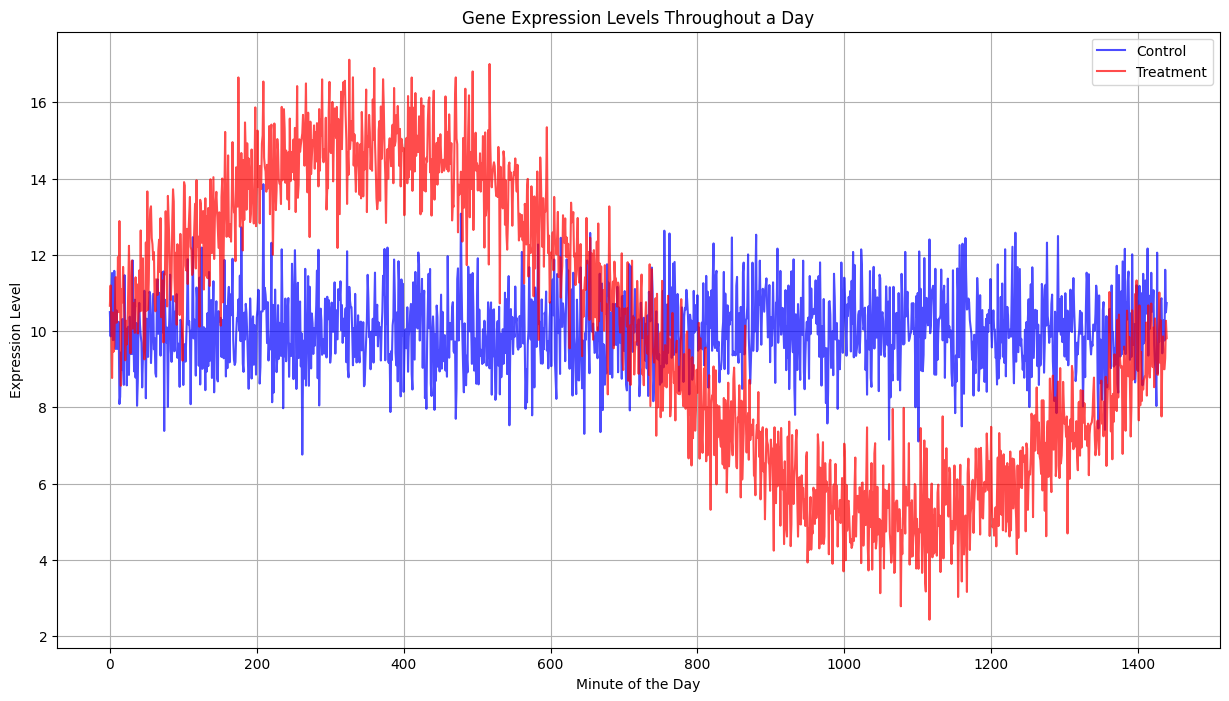

In [46]:
import matplotlib.pyplot as plt

# Load the data from the CSV file
data = pd.read_csv('./gene_expression_levels.csv')

# Plotting
plt.figure(figsize=(15, 8))
plt.plot(data['Minute of the Day'], data['Control Expression Level'], label='Control', color='blue', alpha=0.7)
plt.plot(data['Minute of the Day'], data['Treatment Expression Level'], label='Treatment', color='red', alpha=0.7)
plt.title('Gene Expression Levels Throughout a Day')
plt.xlabel('Minute of the Day')
plt.ylabel('Expression Level')
plt.legend()
plt.grid(True)
plt.show()

<h4> Step 3: Creating & Optimizing Linear Kernel </h4>

In this step, we establish and refine our Gaussian Process Regression (GPR) models for both the control and treatment groups by defining a linear kernel and optimizing its parameters.

**Linear Kernel Creation**

We use the DotProduct kernel combined with a Constant kernel, which represents a linear relationship between the input features and the target gene expression levels. This kernel is suitable for datasets where a linear trend might explain the variability in the data.

**Optimization Process**

The optimization process involves tuning the kernel parameters to maximize the likelihood of the data given the model. This is carried out through an iterative process that adjusts the Constant and DotProduct parameters to best fit the observed gene expression levels.

**Optimized Kernel Parameters**

*Control Group*

The optimized kernel parameters are 0.0316**2 * DotProduct(sigma_0=100). This implies that the GP model has learned a relatively stable variance (0.0316**2) in the data with a strong linear component (sigma_0=100).

*Treatment Group*

The optimized parameters are 0.0447**2 * DotProduct(sigma_0=0.0138). Here, the variance is slightly higher than in the control group, indicating more variability in the treatment group's gene expression levels. The sigma_0 parameter close to zero suggests that the linear trend is less pronounced in the treatment group.

**Implications, Next Steps**

The difference in optimized parameters between the control and treatment groups suggests that the treatment might be influencing gene expression levels, albeit not in a straightforward linear manner. This observation will guide our subsequent analysis, where we will compare the predictions of these models and assess the impact of the treatment on gene expression.
With the optimized models in hand, we are now equipped to predict gene expression levels and quantify the confidence in these predictions, laying the groundwork for statistical comparisons in the following steps.

In [47]:
from sklearn.gaussian_process.kernels import DotProduct, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split

# Reducing data for demonstration
minutes_sub = minutes[::10].reshape(-1, 1)
control_expression_sub = control_expression[::10]
treatment_expression_sub = treatment_expression[::10]

# Split the data into training and testing sets
X_train_control, X_test_control, y_train_control, y_test_control = train_test_split(
    minutes_sub, control_expression_sub, test_size=0.2, random_state=42)

X_train_treatment, X_test_treatment, y_train_treatment, y_test_treatment = train_test_split(
    minutes_sub, treatment_expression_sub, test_size=0.2, random_state=42)

# Define a linear kernel
linear_kernel = C(1.0, (1e-3, 1e3)) * DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-2, 1e2))

# Initialize the Gaussian Process Regressor for the control group with the linear kernel
gp_control_linear = GaussianProcessRegressor(kernel=linear_kernel, n_restarts_optimizer=10)

# Fit the model to the control data (using the same training points)
gp_control_linear.fit(X_train_control, y_train_control)

# Initialize the Gaussian Process Regressor with the linear kernel
gp_treatment_linear = GaussianProcessRegressor(kernel=linear_kernel, n_restarts_optimizer=10)

# Fit the model to the treatment data
gp_treatment_linear.fit(X_train_treatment, y_train_treatment)

# Make predictions for the control group using the model fitted with the linear kernel
y_control_linear_pred, sigma_control_linear = gp_control_linear.predict(X_test_control, return_std=True)

# Make predictions using the model fitted with the linear kernel
y_linear_pred, sigma_linear = gp_treatment_linear.predict(X_test_treatment, return_std=True)

# Print the optimized kernel parameters for the control model
print("Optimized kernel parameters for control:", gp_control_linear.kernel_)

# Print the optimized kernel parameters
print("Optimized kernel parameters for treatment:", gp_treatment_linear.kernel_)

Optimized kernel parameters for control: 0.0316**2 * DotProduct(sigma_0=100)
Optimized kernel parameters for treatment: 0.0447**2 * DotProduct(sigma_0=0.0138)


c:\Users\jhavi\Downloads\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\jhavi\Downloads\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__sigma_0 is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\jhavi\Downloads\.venv\Lib\site-packages\sklearn\gaussian_process\_gpr.py:479: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(


<h4> Step 4: Prediction & Confidence Interval Visualization </h4>

This section illustrates the results of our Gaussian Process Regression (GPR) analysis, showcasing the model's ability to predict gene expression levels and quantify uncertainty.

**Control Group Predictions**

The first plot represents the predictions for the control group. Here, we observe the red dots indicating the actual training observations, while the blue line represents the GPR model's predictions. The shaded area depicts the 95% confidence interval, reflecting the uncertainty in the predictions. The stability in the expression levels and the tight confidence intervals suggest that the control group's gene expression is consistent over time, with minimal fluctuations.

**Treatment Group Predictions**

The second plot visualizes the predictions for the treatment group. Similar to the control group, the red dots show the training data. However, unlike the control group, we notice a distinct downward trend in the model's predictions, which is indicated by the blue line. This trend signifies a decrease in gene expression levels as time progresses throughout the day. The confidence interval for the treatment group is wider than for the control group, indicating greater uncertainty in the model's predictions, likely due to the higher variability in gene expression levels post-treatment.

**Interpreting Confidence Intervals**

Confidence intervals are pivotal as they provide insight into the reliability of the model's predictions. A narrow confidence interval, as seen with the control group, suggests higher certainty in the model's outputs. In contrast, a broader interval, as with the treatment group, highlights the greater inherent variability and suggests that additional factors may influence gene expression beyond the modeled features.

The side-by-side comparison of these plots emphasizes the differential impact of the treatment on gene expression. While the control group maintains a steady baseline, the treatment group demonstrates a clear and quantifiable change. As we proceed, we'll employ statistical tests to determine if the differences observed here are significant and to assess the impact of the treatment more rigorously.
With these visualizations, we have established a foundation for statistical comparison and further validation of the treatment's effects on gene expression.

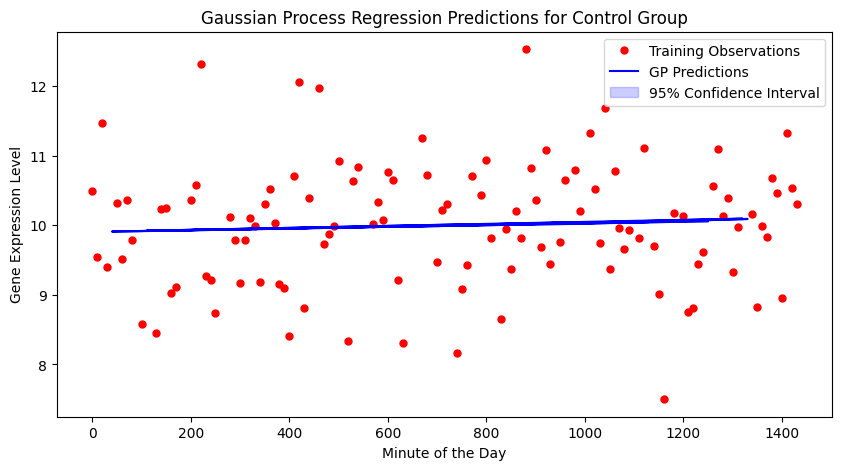

In [48]:
y_control_pred, sigma_control = gp_control_linear.predict(X_test_control, return_std=True)

# Visualization of the control group predictions
plt.figure(figsize=(10, 5))
plt.plot(X_train_control, y_train_control, 'r.', markersize=10, label='Training Observations')
plt.plot(X_test_control, y_control_pred, 'b-', label='GP Predictions')
plt.fill_between(X_test_control.ravel(), y_control_pred - 1.96 * sigma_control, 
                 y_control_pred + 1.96 * sigma_control, alpha=0.2, 
                 color='blue', label='95% Confidence Interval')
plt.xlabel('Minute of the Day')
plt.ylabel('Gene Expression Level')
plt.title('Gaussian Process Regression Predictions for Control Group')
plt.legend()
plt.show()

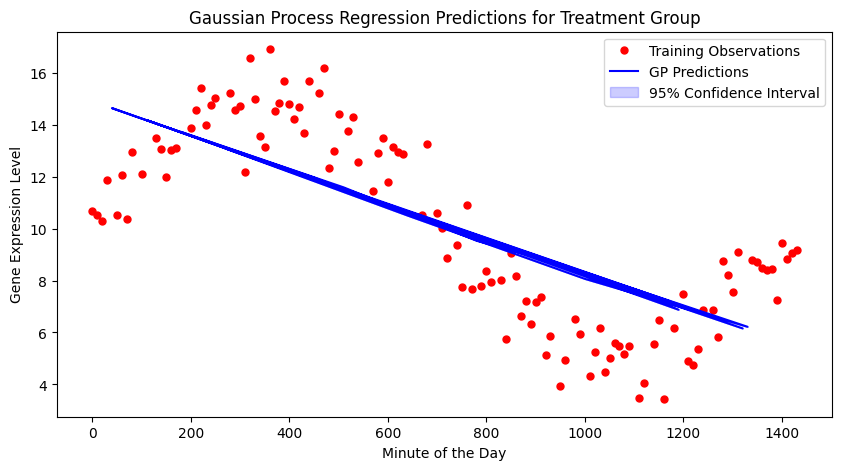

In [51]:
plt.figure(figsize=(10, 5))
plt.plot(X_train_treatment, y_train_treatment, 'r.', markersize=10, label='Training Observations')
plt.plot(X_test_treatment, y_linear_pred, 'b-', label='GP Predictions')
plt.fill_between(X_test_treatment.ravel(), y_linear_pred - 1.96 * sigma_linear, y_linear_pred + 1.96 * sigma_linear, alpha=0.2, color='blue', label='95% Confidence Interval')
plt.xlabel('Minute of the Day')
plt.ylabel('Gene Expression Level')
plt.title('Gaussian Process Regression Predictions for Treatment Group')
plt.legend()
plt.show()

<h4> Step 5: T-Statistic & P-Value </h4>

This step involves the application of a t-test to assess whether there is a statistically significant difference in gene expression levels between the control and treatment groups based on our Gaussian Process Regression model's predictions.

**Statistical Test Outcome**

The t-test yields a T-statistic of -0.7623008297537783 and a P-value of 0.44907944121035237.

**Interpretation of Results**

*T-Statistic*: The negative value of the T-statistic suggests that the mean gene expression level predicted for the treatment group is lower than that of the control group. However, the magnitude of this statistic is relatively small, indicating a modest difference between the two means.

*P-Value*: The P-value exceeds the common alpha level of 0.05, suggesting that we cannot reject the null hypothesis. In the context of our study, this means there is no statistically significant evidence to conclude that the treatment has an effect on gene expression levels, as modeled by our Gaussian Process Regression.

**Considerations**

It is important to note that the lack of statistical significance does not necessarily imply that the treatment has no biological effect. Instead, it may suggest that the effect is not captured within the scope of our current modeling approach, or that the variability within the groups is too high relative to the difference between the group means.

In [52]:
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(y_control_linear_pred, y_linear_pred)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -0.7623008297537783, P-value: 0.44907944121035237


### Conclusion

As we culminate our exploration into gene expression data through Gaussian Process Regression (GPR) modeling and statistical testing, a juxtaposition of our findings presents a complex picture.

**Discrepancy Between Visual Patterns and Statistical Inference**

- The initial data visualization indicates a notable cyclical pattern in the treatment group's gene expression levels throughout the day, which contrasts with the control group's relatively stable expression levels.

- GPR predictions for the control group corroborate the visual analysis, presenting a consistent gene expression level with tight confidence intervals. In contrast, the predictions for the treatment group depict a steady decline over time, failing to capture the observed cyclical nature.

- The optimized kernel parameters for the control and treatment models further emphasize this contrast: the control group's kernel suggests a strong linear trend, while the treatment's low sigma_0 value indicates a less pronounced linear component.

**Statistical Results Vs. Predictive Modeling**

Despite the visual and predictive modeling evidence suggesting differing behavior between control and treatment groups, the t-test yields a non-significant p-value (0.449), implying no statistical evidence to reject the null hypothesis of equal means. This incongruity raises important considerations:

- The choice of the linear kernel may have led to underfitting in the treatment group, given the cyclicality in the data. This misalignment would affect the model's ability to predict and, consequently, the outcome of the t-test.

- The t-statistic itself (-0.7623) points to a difference in the means; however, the lack of statistical significance suggests that this difference is not robust against the variability within the groups.

**Reflections & Implications for Future Analysis**

Our findings elucidate the criticality of kernel selection in GPR. A linear kernel may be inadequate for data with non-linear trends, as is evident in the treatment group's gene expression data.

The inconclusive statistical results urge a reconsideration of our modeling approach, potentially incorporating non-linear kernels that can grasp the cyclical expression patterns influenced by external factors like treatment.

A more nuanced modeling approach may offer stronger statistical power, yielding results that resonate with the visual and predictive analyses, ultimately providing clearer insights into the treatment's impact on gene expression.


In conclusion, while the GPR analysis offered detailed predictions and an appreciation of the underlying data structure, it underscored the importance of aligning the model with the data's inherent complexity. Future analysis will benefit from a kernel that captures both linear trends and cyclicality, ensuring that the statistical testing faithfully represents the biological phenomena at play.

### References

ChatGPT - https://chat.openai.com/

CS courses Padlet by Professor Isac Artzi - https://padlet.com/isac_artzi/cs-courses-97zpvui7fpar

StatQuest: A gentle introduction to RNA-seq - https://www.youtube.com/watch?v=tlf6wYJrwKY